In [ ]:
!pip install roboflow
%pip install rembg
from rembg import remove
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from roboflow import Roboflow
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Conv2DTranspose, concatenate,MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Переменные

In [ ]:
n_class = 26
TRAIN_DIR  = '/content/Car_segmentation_project-7/train'
VAL_DIR = '/content/Car_segmentation_project-7/valid'
paths = '/content/Test'
path_test = '/content/drive/MyDrive/Test/Test'
IMG_WIDTH = 720
IMG_HEIGHT = 1280
max_width = 1280 # Ширина измененного изображения
max_height = 720 # Высота измененного изображения
max_ratio = max_width / max_height # Соотношение сторон
color = 3 # Количество слоёв цветов

In [ ]:
background = (0, 0, 0)
back_bumper = (100, 100, 100)
back_door = (0, 0, 100)
back_lights = (0, 50, 150)
back_pillar_with_back_fender = (50, 0, 150)
back_side_windows = (100, 100, 100)
car_rims = (0, 100, 0)
door_handles_back = (100, 0, 0)
door_handles_front = (200, 50, 5)
fog_light = (255, 255, 30)
front_bumper = (30, 80, 100)
front_door = (80, 0, 100)
front_fender = (100, 150, 200)
front_light = (200, 150, 10)
front_pillars = (80, 30, 100)
front_side_windows = (100, 150, 50)
hood = (140, 110, 180)
indicator_light = (160, 40, 200)
indicator_light_front = (160, 40, 200)
mudguard = (200, 200, 0)
plastic_wheel_arch_trim = (200, 0, 200)
radiator = (255, 255, 255)
rear_view_mirrors = (0, 100, 200)
roof = (200, 0, 0)
side_steps = (0, 60, 200)
tire = (10, 10, 80)
wheel = (0, 30, 255)
windowark = (250, 10, 180)

In [ ]:
CLASS_COLOR = (background,
                back_bumper,
                back_door,
                back_lights,
                back_pillar_with_back_fender,
                back_side_windows,
                car_rims,
                door_handles_back,
                door_handles_front,
                fog_light,
                front_bumper,
                front_door,
                front_fender,
                front_light,
                front_pillars,
                front_side_windows,
                hood,
                indicator_light,
                indicator_light_front,
                mudguard,
                plastic_wheel_arch_trim,
                radiator,
                rear_view_mirrors,
                roof,
                side_steps,
                tire,
                wheel,
                windowark)

In [ ]:
background = (0)
back_bumper = (1)
back_door = (2)
back_lights = (3)
back_pillar_with_back_fender = (4)
back_side_windows = (5)
car_rims = (6)
door_handles_back = (7)
door_handles_front = (8)
fog_light = (9)
front_bumper = (10)
front_door = (11)
front_fender = (12)
front_light = (13)
front_pillars = (14)
front_side_windows = (15)
hood = (16)
indicator_light = (17)
indicator_light_front = (18)
mudguard = (19)
plastic_wheel_arch_trim = (20)
radiator = (21)
rear_view_mirrors = (22)
roof = (23)
side_steps = (24)
tire = (25)
wheel = (26)
windowark = (27)

In [ ]:
CLASS_LABELS = (background,
                back_bumper,
                back_door,
                back_lights,
                back_pillar_with_back_fender,
                back_side_windows,
                car_rims,
                door_handles_back,
                door_handles_front,
                fog_light,
                front_bumper,
                front_door,
                front_fender,
                front_light,
                front_pillars,
                front_side_windows,
                hood,
                indicator_light,
                indicator_light_front,
                mudguard,
                plastic_wheel_arch_trim,
                radiator,
                rear_view_mirrors,
                roof,
                side_steps,
                tire,
                wheel,
                windowark)

In [ ]:
classes = {0: 'background',
           1: 'back_bumper',
           2: 'back_door',
           3: 'back_lights',
           4: 'back_pillar_with_back_fender',
           5: 'back_side_windows',
           6: 'car_rims',
           7: 'door_handles_back',
           8: 'door_handles_front',
           9: 'fog_light',
           10: 'front_bumper',
           11: 'front_door',
           12: 'front_fender',
           13: 'front_light',
           14: 'front_pillars',
           15: 'front_side_windows',
           16: 'hood',
           17: 'indicator_light',
           18: 'indicator_light_front',
           19: 'mudguard',
           20: 'plastic_wheel_arch_trim',
           21: 'radiator',
           22: 'rear_view_mirrors',
           23: 'roof',
           24: 'side_steps',
           25: 'tire',
           26: 'wheel',
           27: 'windowark'}

# Def

In [ ]:
def resize_image(input_folder, output_folder):
  for root, dirs, files in os.walk(input_folder):
    for file_name in files:

      try:
          # Составляем полный путь к входному файлу
          input_path = os.path.join(root, file_name)
          output_path = os.path.join(output_folder, os.path.relpath(input_path, input_folder))
          os.makedirs(os.path.dirname(output_path), exist_ok=True)
          img_file_out = output_path
          img = Image.open(input_path)
          width = img.size[0]
          height = img.size[1]
          if width >= height * max_ratio:
            ratio = width/height
            w = max_width
            h = int(w / ratio)
            if h % 2 >= 1:
              h += 1
            img_1 = Image.open(input_path).resize((int(w), int(h)))
            img_2 = np.array(img_1)
            zero = np.zeros((int(max_height),int(max_width) ,color))
            x1 = int((max_height - h)/2)
            x2 = int(max_height  - x1)
            zero[x1:x2, :, :] = zero[x1:x2, :, :] + img_2
            zero = zero.astype(np.uint8)
            im = Image.fromarray(zero)
            #print(f'Разрешение файла {file_name} = {img.size}')
            #print(f'Разрешение измененного файла = {im.size}')
            im.save(f'{img_file_out}')
          elif width < height * max_ratio:
            ratio = width/height
            h = max_height
            w = int(h * ratio)
            if w % 2 >= 1:
              w += 1
            img_1 = Image.open(input_path).resize((int(w), int(h)))
            img_2 = np.array(img_1)
            zero = np.zeros((int(max_height),int(max_width) ,color))
            x1 = int((max_width - w)/2)
            x2 = int(max_width  - x1)
            zero[:, x1:x2, :] = zero[:, x1:x2, :] + img_2
            zero = zero.astype(np.uint8)
            im = Image.fromarray(zero)
            #print(f'Разрешение файла {file_name} = {img.size}')
            #print(f'Разрешение измененного файла = {im.size}')
            im.save(f'{img_file_out}')
      except Exception as e:
          print(f"Ошибка при обработке {file_name}: {str(e)}")

In [ ]:
def t_v_data(path):
  file_list = os.listdir(path)
  x_train = []
  y_train = []
  import re
  for i in range(len(file_list)):
    if file_list[i] == '_classes.csv':
      ni = ''
    else:
      match = re.search(r'\_mask.', file_list[i])
      if match:
        img = Image.open(path + '/' + file_list[i])
        img_np = np.array(img)
        y_train.append(img_np)
      else:
        img = Image.open(path + '/' + file_list[i])
        img_np = np.array(img)
        x_train.append(img_np)
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  return x_train, y_train

In [ ]:
def t_v_data_1(path):
  file_list = os.listdir(path)
  x_train = []
  y_train = []
  import re
  for i in range(len(file_list)):
    if file_list[i] == '_classes.csv':
      ni = ''
    else:
      match = re.search(r'\_mask.', file_list[i])
      if match:
        img = Image.open(path + '/' + file_list[i])
        img_np = np.array(img)
        y_train.append(img_np)
      else:
        input_image = Image.open(path + '/' + file_list[i])
        img = remove(input_image)
        img_np = np.array(img)
        x_train.append(img_np)
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  return x_train, y_train

In [ ]:
# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list  # список цветных изображений
                 ):

    result = []

    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)
        # Создание пустой 1-канальной картики
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(sample == CLASS_LABELS[i])] = i

        result.append(y)

    return np.array(result)

In [ ]:
# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений
                 ):

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картики
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение пикселов класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_COLOR[i]

        result.append(temp)

    return np.array(result)

In [ ]:
def unet(input_size=(720,1280,3), n_classes=n_class):

    img_input = Input(input_size)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 2 '''
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 3 '''
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 4 '''
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out

    ''' UP 2 '''
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 3 '''
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 4 '''
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)      # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(n_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    return model


In [ ]:
def unet_2(input_size=(720,1280,4), n_classes=n_class):

    img_input = Input(input_size)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 2 '''
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 3 '''
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 4 '''
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out

    ''' UP 2 '''
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 3 '''
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 4 '''
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)      # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(n_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    return model


In [ ]:
def predict_model(model, x_test):

  indexes = np.random.randint(0, len(x_test), 5)
  # Вычисление предсказания сети для картинок с отобранными индексами
  orig = np.argmax(model.predict(x_test[indexes]), axis=-1)
  fig, axs = plt.subplots(2, 5, figsize=(20, 6))

  # Отрисовка результата работы модели
  for i in range(5):
      # Отображение на графике предсказания модели
      axs[0, 0].set_title('Результат работы модели:')
      axs[0, i].imshow(orig[i])
      axs[0, i].axis('off')

      # Отображение на графике оригинального изображения
      axs[1, 0].set_title('Оригинальное изображение')
      axs[1, i].imshow(x_test[indexes[i]])
      axs[1 ,i].axis('off')

  plt.show()

In [ ]:
def test_img(path_test):

  data_files = os.listdir(path_test)
  resize_image(path_test, paths)
  data_file = []
  for files in data_files:
    vv = paths + '/' + files
    data_file.append(vv)
  data_images = []
  for file_name in data_file:
      input_image = Image.open(file_name)
      img = remove(input_image)
      img_np = np.array(img)
      data_images.append(img_np)
  x_test = np.array(data_images)
  print(x_test.shape)
  return x_test

# Загрузка датасета из Roboflow

In [ ]:
rf = Roboflow(api_key="31SiQSiPEHuJCRNbuC0h")
project = rf.workspace("project-z5fyn").project("car_segmentation_project")
dataset = project.version(7).download("png-mask-semantic")
#dataset = project.version(2).download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Car_segmentation_project-7 in png-mask-semantic:: 100%|██████████| 48/48 [00:00<00:00, 4647.32it/s]


# Обработка фотографий

In [ ]:
len(os.listdir(VAL_DIR))

5

In [ ]:
x_train, y_train_seg = t_v_data(TRAIN_DIR)
x_val, y_val_seg = t_v_data(VAL_DIR)
print(x_train.shape)
print(y_train_seg.shape)
print(x_val.shape)
print(y_val_seg.shape)
#y_train = np.array(y_train_seg).reshape(19,720,1280,-1)
#y_val = np.array(y_val_seg).reshape(2,720,1280,-1)
y_train = rgb_to_labels(y_train_seg)
y_val = rgb_to_labels(y_val_seg)
print(y_train.shape)
print(y_val.shape)

(19, 720, 1280, 3)
(19, 720, 1280)
(2, 720, 1280, 3)
(2, 720, 1280)
(19, 720, 1280, 1)
(2, 720, 1280, 1)


# Модель

In [ ]:
model = unet_2()

In [ ]:
model = load_model('/content/drive/MyDrive/model_u_net.keras')

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-10),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
#model.summary()

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data = (x_val, y_val),
    epochs=80,
    batch_size = 1
)

Epoch 1/80
19/19 [==============================] - 26s 853ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.9584 - val_loss: 1.0420 - val_sparse_categorical_accuracy: 0.7672
Epoch 2/80
19/19 [==============================] - 16s 822ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.9584 - val_loss: 1.0421 - val_sparse_categorical_accuracy: 0.7671
Epoch 3/80
19/19 [==============================] - 16s 838ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.9584 - val_loss: 1.0418 - val_sparse_categorical_accuracy: 0.7672
Epoch 4/80
19/19 [==============================] - 16s 834ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.9584 - val_loss: 1.0423 - val_sparse_categorical_accuracy: 0.7672
Epoch 5/80
19/19 [==============================] - 16s 824ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.9584 - val_loss: 1.0414 - val_sparse_categorical_accuracy: 0.7672
Epoch 6/80
19/19 [==============================] - 16s 826ms/step - loss: 0.1676 - sparse_cate

# Проверка на тестовых изображениях

In [ ]:
x_test = test_img(path_test = '/content/drive/MyDrive/Test/Test')

In [ ]:
model = load_model('/content/drive/MyDrive/model_u_net_2.keras')

1/1 [==============================] - 0s 25ms/step


IndexError: ignored

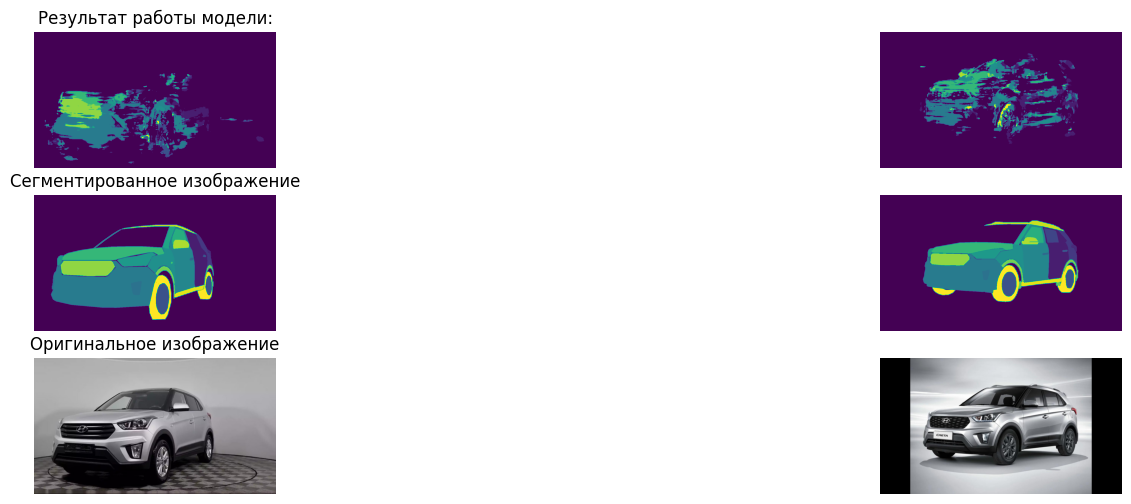

In [ ]:
#indexes = np.random.randint(0, len(x_val), 1)
indexes = [0, 1]
indexes[0] = 0
indexes[1] = 1
# Вычисление предсказания сети для картинок с отобранными индексами
orig = np.argmax(model.predict(x_val), axis=-1)
fig, axs = plt.subplots(3, 2, figsize=(20, 6))

# Отрисовка результата работы модели
for i in range(5):
    # Отображение на графике предсказания модели
    axs[0, 0].set_title('Результат работы модели:')
    axs[0, i].imshow(orig[i])
    axs[0, i].axis('off')

    axs[1, 0].set_title('Сегментированное изображение')
    axs[1, i].imshow(y_val[i])
    axs[1, i].axis('off')

    # Отображение на графике оригинального изображения
    axs[2, 0].set_title('Оригинальное изображение')
    axs[2, i].imshow(x_val[indexes[i]])
    axs[2 ,i].axis('off')

In [ ]:
predict_model(model, x_val)

ValueError: ignored

In [ ]:
model.save('/content/drive/MyDrive/model_u_net_3.keras')